# Benchmarking IQM Star

This notebook allows you to run some useful benchmarks for the Star system.

## Connect to the backend

In [1]:
import os
from iqm.qiskit_iqm import IQMProvider
import random

QPU = "deneb" # or any other star QPU
token = ""
os.environ["IQM_TOKEN"] = token

iqm_url = "https://cocos.resonance.meetiqm.com/" + QPU
provider = IQMProvider(iqm_url)
backend = provider.get_backend()

C:\Users\RaphaelBrieger\miniconda3\envs\iqm-benchmarks\Lib\site-packages\iqm\iqm_client\iqm_client.py:140: UserWarning: Your IQM Client version 22.8 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 20.8 <= iqm-client < 22.0.
  warnings.warn(version_incompatibility_msg)


We can access the Star backend and plot its connectivity graph to check that everything is working properly.

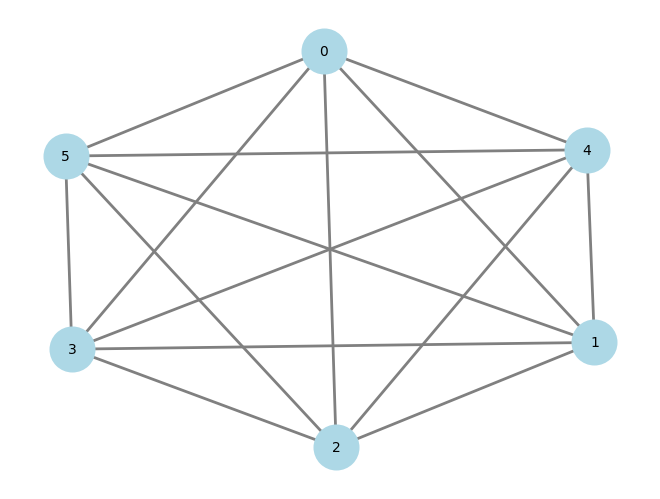

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

coupling_map = backend.coupling_map

G = nx.Graph()
G.add_edges_from(coupling_map) 
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', 
        node_size=1000, font_size=10, linewidths=1.5, width=2)
plt.show()

We run the cell below to ignore those warnings that are not critical for the correct run of the benchmarks.

In [3]:
import warnings
warnings.filterwarnings(action="ignore")  

## GHZ state fidelity

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits, $n$. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1, i.e., $| GHZ \rangle = \frac{1}{\sqrt{2}}(|0\rangle^{\otimes n}+|1\rangle^{\otimes n})$.

The GHZ state fidelity acts as a **witness** for genuine multi-qubit entanglement if found to be above $0.5$. This means that the measurement results cannot be explained without entanglement involving **all** qubits, so it is a great way to evaluate the "quantumness" of the computer. 

The state $\rho_{\text{ideal}}= |GHZ\rangle\langle GHZ|$ is a pure state, so in this case the fidelity can be computed as:

$$
F(\text{ideal}, \text{measured})= \langle GHZ | \rho_{\text{measured}} | GHZ \rangle,$$

where $\rho_{\text{measured}}$ is the density matrix given by the actual results of the quantum computer. The ideal GHZ state density matrix entries can be written as $\rho_{i,j}=\langle i| \rho_{\text{ideal}} | j \rangle$ where $i,j$ are the $n$ basis states $\{|00..0\rangle, ..., |11..1\rangle\}$; only the corner entries $\rho_{0,0},\rho_{0,n},\rho_{n,0}$ and $\rho_{n,n} $ are non-zero. This simplifies the process since we only need to measure these four components. In the fidelity formula, all other entries are effectively nullified by the zero entries in the ideal state matrix. To measure the coherences (off-diagonal entries) we use the method of multiple quantum coherences [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta). 

In [5]:
from iqm.benchmarks.entanglement.ghz import GHZConfiguration, GHZBenchmark

In [6]:
num_qubits = backend.num_qubits
chosen_layout = [list(range(qubits)) for qubits in range(2,num_qubits+1)]
GHZ = GHZConfiguration(
    state_generation_routine="star",
    custom_qubits_array=chosen_layout,
    shots=2000,
    fidelity_routine="coherences", 
    rem=True,
    mit_shots=1000,
)

In [7]:
benchmark_ghz = GHZBenchmark(backend, GHZ)
run_ghz = benchmark_ghz.run()

2025-03-14 16:42:11,866 - iqm.benchmarks.logging_config - INFO - Now generating a 2-qubit GHZ state on qubits [0, 1]
2025-03-14 16:42:11,868 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-03-14 16:42:12,665 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-03-14 16:42:12,936 - iqm.benchmarks.logging_config - INFO - Submitting batch with 7 circuits corresponding to qubits [0, 1]
2025-03-14 16:42:13,384 - iqm.benchmarks.logging_config - INFO - Now generating a 3-qubit GHZ state on qubits [0, 1, 2]
2025-03-14 16:42:13,384 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-03-14 16:42:13,429 - iqm.benchmarks.logging_config - INFO - Tr

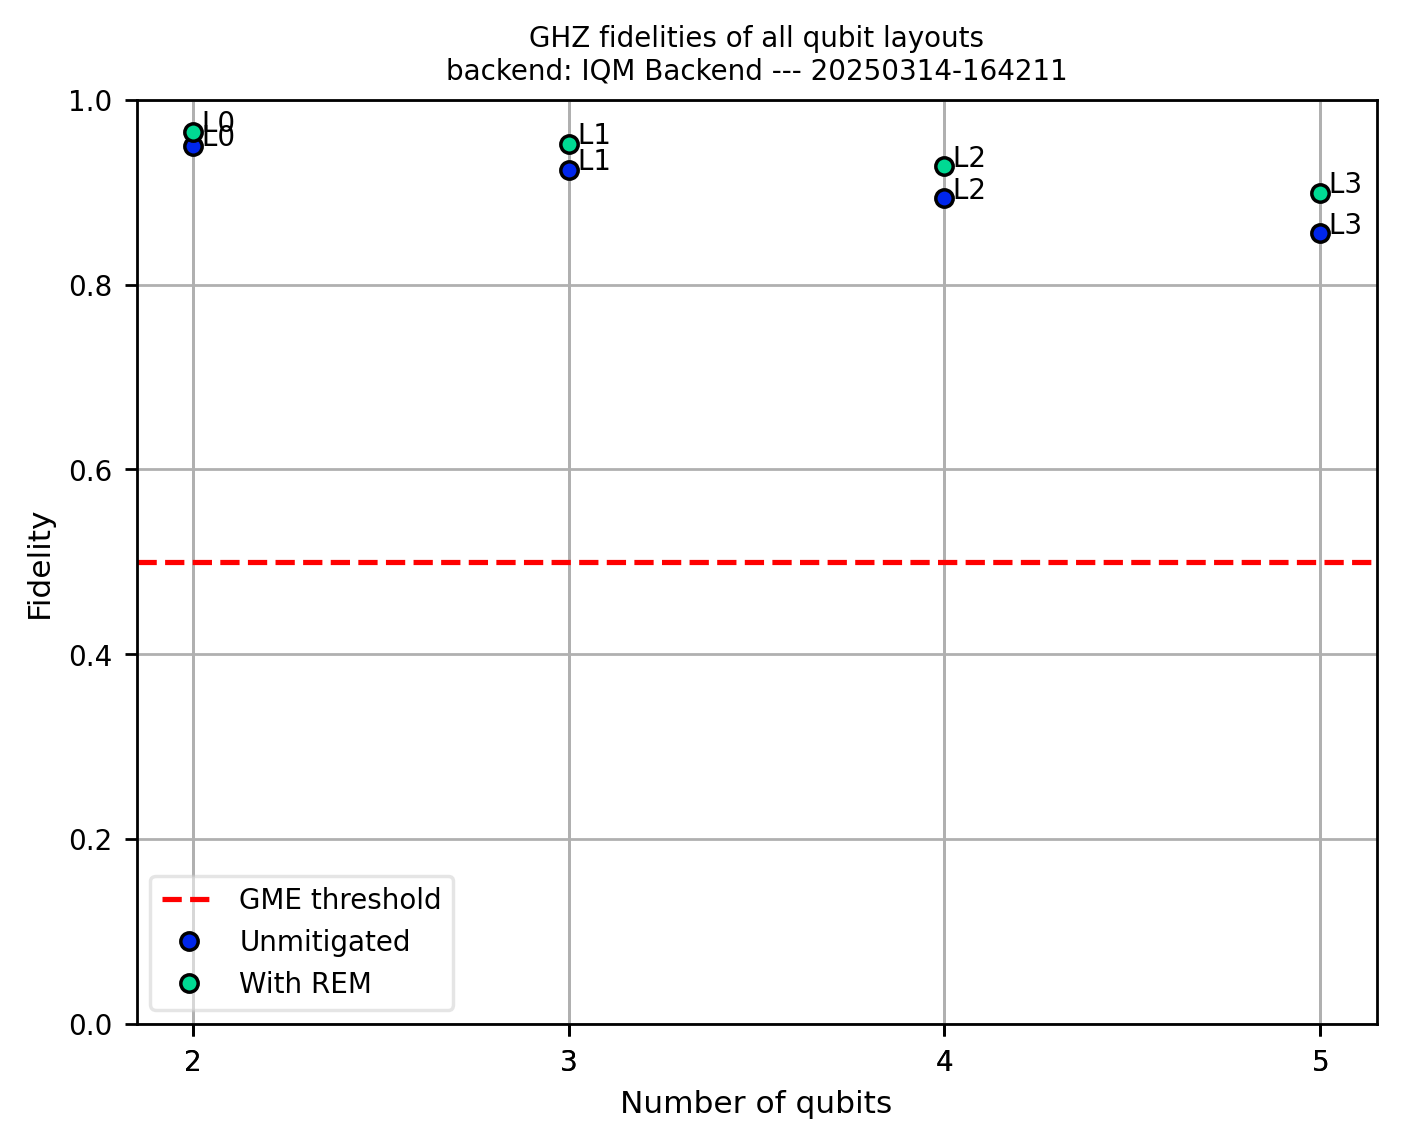

In [8]:
result_ghz = benchmark_ghz.analyze()
result_ghz.plot_all()

## Quantum Volume

Quantum volume is a single-number metric that was introduced in [Cross, 2019](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.032328). It evaluates the quality of a quantum processor via the largest random *square* circuit, i.e., with the same number of layers of parallel random 2-qubit unitaries as number of qubits, that it can run successfully.

The success of a run is based on the heavy output probability, which corresponds to the probability of observing *heavy outputs*, i.e. the measurement outputs that occcur with a probability greater than the median of the distribution. The heavy output generation problem asks if the generated distribution of the random circuit we run contains heavy outputs at least 2/3 of the time (on average) with a high confidence level, typically higher than 97.5%. It can be shown that the heavy output probability for an ideal device is at around 0.85 asymptotically. 
The quantum volume is then defined as

$$\log_2 V_q = \underset{n}{\text{argmax}} \min (n, d(n))$$

where $n \leq N$ is a number of qubits and $d(n)$ is the *achievable depth*, i.e. the largest depth such that we are confident the probability of observing a heavy output is greater than 2/3.


In [10]:
from iqm.benchmarks.quantum_volume.quantum_volume import QuantumVolumeConfiguration, QuantumVolumeBenchmark

We define a combination of qubits to test quantum volume on.

In [11]:
chosen_layouts = [[0,2,3]] ## choose the optimal layouts to run
QV = QuantumVolumeConfiguration(
    num_circuits=500, 
    shots=2**8,
    calset_id=None,
    num_sigmas=2,
    choose_qubits_routine="custom",
    custom_qubits_array=chosen_layouts, 
    qiskit_optim_level=3,
    optimize_sqg=True,
    max_gates_per_batch=10_000,
    rem=True,
    mit_shots=1_000,
)

> If you want to modify the settings above, please refer to the documentation [here](https://iqm-finland.github.io/iqm-benchmarks/api/iqm.benchmarks.quantum_volume.quantum_volume.QuantumVolumeConfiguration.html#iqm.benchmarks.quantum_volume.quantum_volume.QuantumVolumeConfiguration).

Warning: The following code cell may take few minutes to run since it will compute the benchmark on all the qubit layouts specified above.

In [12]:
benchmark_qv = QuantumVolumeBenchmark(backend, QV)
run_qv = benchmark_qv.run()

2025-03-14 16:45:14,314 - iqm.benchmarks.logging_config - INFO - Executing QV on qubits [0, 2, 3]
2025-03-14 16:45:15,655 - iqm.benchmarks.logging_config - INFO - Successfully generated all 500 circuits to be executed
2025-03-14 16:45:15,657 - iqm.benchmarks.logging_config - INFO - Will transpile according to "fixed" physical layout
2025-03-14 16:45:15,658 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-03-14 16:46:04,018 - iqm.benchmarks.logging_config - INFO - Submitting batch with 500 circuits corresponding to qubits [0, 2, 3]
2025-03-14 16:46:04,033 - iqm.benchmarks.logging_config - INFO - max_gates_per_batch restriction: submitting subbatch #1 with 192 circuits corresponding to qubits [0, 2, 3]
2025-03-14 16:46:05,443 - iqm.benchmarks.logging_config - INFO - max_gates_per_batch restriction: submitting subbatch #2 with 192 circuits corresponding to qubits [0, 2,

2025-03-14 16:47:41,326 - iqm.benchmarks.logging_config - INFO - Noiseless simulation and post-processing for layout [0, 2, 3]
2025-03-14 16:47:42,554 - iqm.benchmarks.logging_config - INFO - REM post-processing for layout [0, 2, 3] with 1000 shots


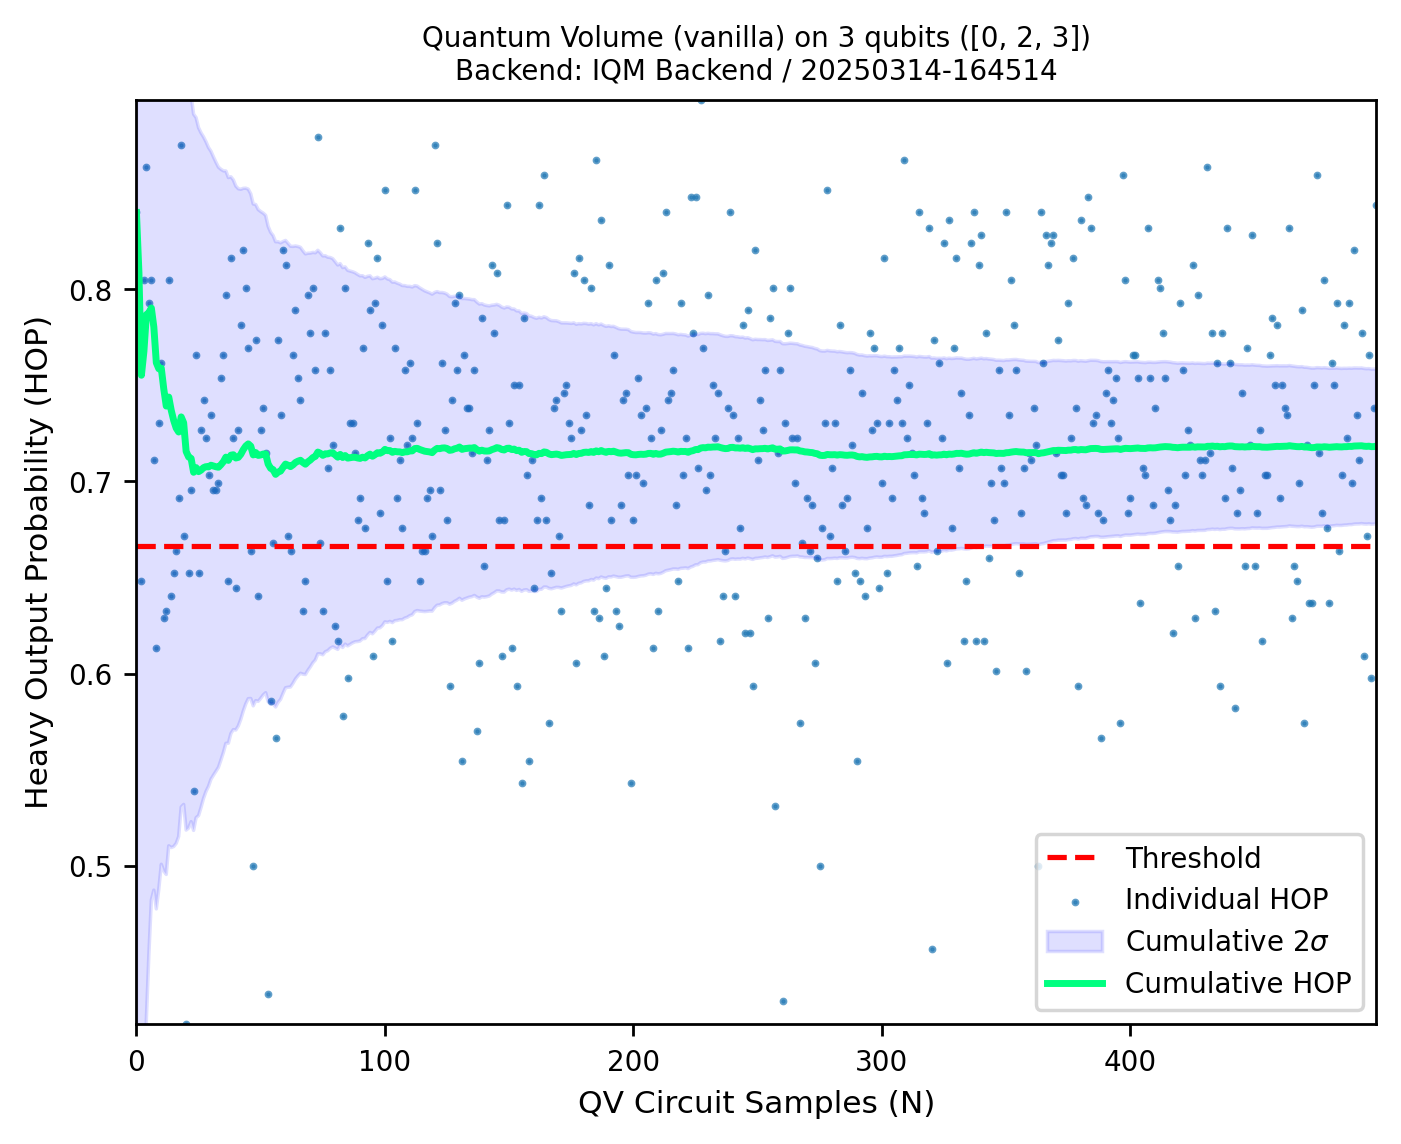

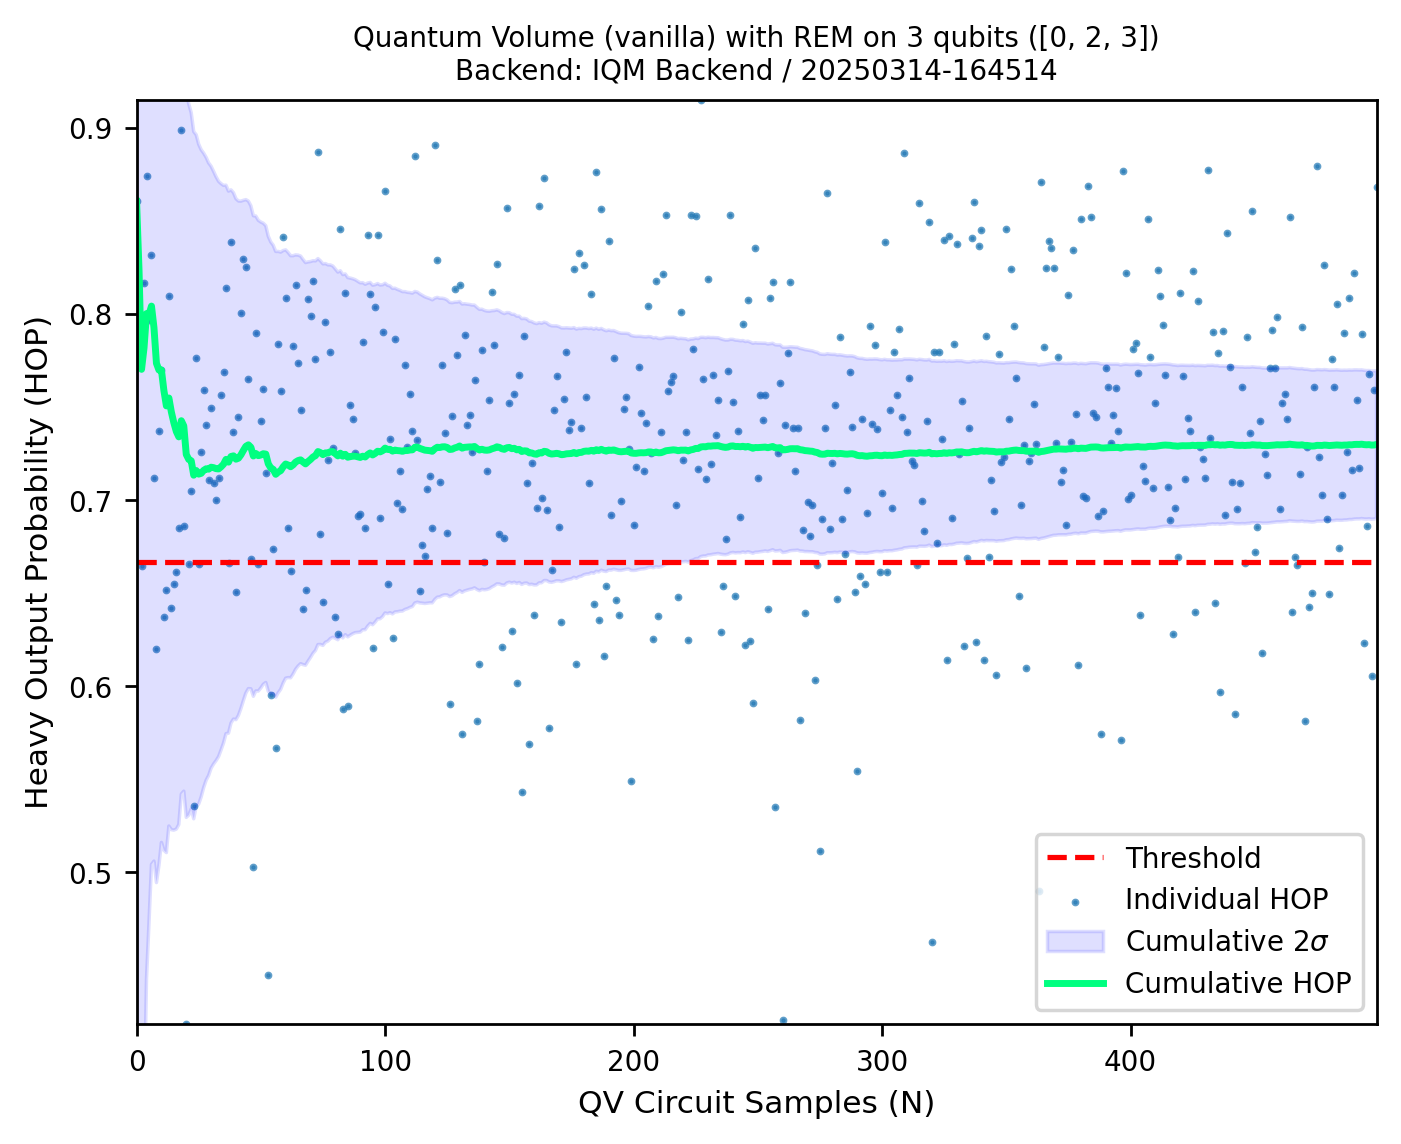

In [13]:
result_qv = benchmark_qv.analyze()
for v in result_qv.plots.values():
    display(v)

## Circuit Layer Operations Per Second (CLOPS)

CLOPS is a metric that estimates the speed at which a quantum computer can execute Quantum Volume (QV) layers of a quantum circuit. That is, the circuits to calculate this benchmark have the same structure as the ones used for QV. Here we follow the definition introduced in ([Wack, 2021](https://arxiv.org/abs/2110.14108)), but other versions of this benchmark exist. 

CLOPS is measured by means of a quantum variational-like protocol, where templates of parametrized QV circuits are assigned random parameters, executed, and outcomes are used as a seed to assign new parameters and repeat the process. The ratio of number of templates ($M$), parameter updates ($K$), measurement shots ($S$) and QV layers ($\log_2\mathrm{QV}$) with the time taken to run all, constitutes the CLOPS value: 

$$
\mathrm{CLOPS}=M\times{K}\times{S}\times\log_2\mathrm{QV}/\mathrm{total\_time}.
$$

Notice that the total CLOPS time includes that of assignment of parameters, submission of circuits and retrieval of results.

In [14]:
from iqm.benchmarks.quantum_volume.clops import CLOPSConfiguration, CLOPSBenchmark, plot_times

In [15]:
CLOPS = CLOPSConfiguration(
    qubits=[0,2,3], # run with the same layout as 
    num_circuits=100,
    num_updates=10, 
    num_shots=100, 
    calset_id=None,
    qiskit_optim_level=3,
    optimize_sqg=True,
    routing_method="sabre",
    physical_layout="fixed",
)

> If you want to modify the settings above, please refer to the documentation [here](https://iqm-finland.github.io/iqm-benchmarks/api/iqm.benchmarks.quantum_volume.clops.CLOPSConfiguration.html#iqm.benchmarks.quantum_volume.clops.CLOPSConfiguration).

In [ ]:
benchmark_clops = CLOPSBenchmark(backend, CLOPS)
run_clops = benchmark_clops.run()

In [ ]:
result_clops = benchmark_clops.analyze()
fig_clops = plot_times(result_clops.dataset, result_clops.observations)
display(fig_clops[1])

## Q-Score

*The Q-score measures the maximum number of qubits that can be used
effectively to solve the MaxCut combinatorial optimization problem with the Quantum Approximate
Optimization Algorithm* - [Martiel,2021](https://ieeexplore.ieee.org/document/9459509)

The graphs chosen for the benchmark are random Erdős-Rényi graphs with 50% edge-probability between nodes.
The obtained cost of the solution, i.e. the average number of cut edges, must be above a certain threshold. Specifically, one has to find the cost of a graph to be above $\beta\geq 0.2$ on a scale where $\beta = 0$ corresponds to a random solution and $\beta = 1$ to an ideal solution. 

In [17]:
from iqm.benchmarks.optimization.qscore import QScoreConfiguration, QScoreBenchmark

In [18]:
num_qubits = backend.num_qubits
chosen_layout = [list(range(qubits)) for qubits in range(1,num_qubits+1)]
QSCORE = QScoreConfiguration(
    num_instances = 1,
    num_qaoa_layers= 1,
    shots = 10000,
    calset_id=None, 
    min_num_nodes = 2,
    max_num_nodes = None,
    use_virtual_node = True,
    use_classically_optimized_angles = True,
    choose_qubits_routine = "custom",
    custom_qubits_array=chosen_layout,
    seed = random.randint(1, 999999),
    REM = True,
    mit_shots = 1000,
    qpu_topology = "star",
    )

> If you want to modify the settings above, please refer to the documentation [here](https://iqm-finland.github.io/iqm-benchmarks/api/iqm.benchmarks.optimization.qscore.QScoreConfiguration.html#iqm.benchmarks.optimization.qscore.QScoreConfiguration).

Warning: The following code cell may take **several** minutes to run.

In [ ]:
benchmark_qscore = QScoreBenchmark(backend, QSCORE)
run_qscore = benchmark_qscore.run()

In [ ]:
result_qscore = benchmark_qscore.analyze()

In [ ]:
result_qscore.plot_all()

## Summary

In [ ]:
import numpy as np

### GHZ
obs_ghz = result_ghz.observations
fidelity = round(min([obs_ghz[i].value for i in range(len(obs_ghz)) if obs_ghz[i].name=='fidelity']),2)

### QV
obs_qv = result_qv.observations
qv = max([obs_qv[i].value for i in range(len(obs_qv)) if obs_qv[i].name=='QV_result'])

### CLOPS
obs_clops = result_clops.observations
clops = max([obs_clops[item]['clops_v']['value'] for item in obs_clops])

### QS 
obs_qs = result_qscore.observations
qs = np.argmin([obs_qs[i].value-0.2 for i in range(len(obs_qs)) if obs_qs[i].name == 'mean_approximation_ratio' and obs_qs[i].value-0.2>0])+2


summary = {'GHZ state fidelity': ['≥ 0.5', fidelity],
    'Quantum Volume': qv, 
    'CLOPS':  clops, 
    'Q-Score':  qs 
}


In [ ]:
summary